In [202]:
import os

import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, chi2, SelectPercentile, SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib as mpl

# import seaborn as sns

In [203]:
# set some constants
RANDOM_STATE=42
TESTSIZE = 0.2
VALSIZE = 0.2
# number of features to select
NUMFEATURES = 5
# or a top percentile of features by importance to select
PERCFEATURES = 20
# name of the target columns
TARGET = 'CONDITION'

In [204]:
def load_datasets():
    datasets = dict()
    dataset_names = []
    for filename in os.listdir('data'):
        path = os.path.join('data', filename)
        dname = filename.split('.')[0]
        if dname == 'PHQ9_GAD7_df':
            sep=';'
        else:
            sep=','
        datasets[dname] = pd.read_csv(path, sep=sep)
        dataset_names.append(dname)
        print(f"Loaded {filename} as {dname}")
    return datasets, dataset_names

In [205]:
datasets, dataset_names = load_datasets()

Loaded BF_df_CTU.csv as BF_df_CTU
Loaded BF_df_OU.csv as BF_df_OU
Loaded BF_df_V.csv as BF_df_V
Loaded IADQ_df.csv as IADQ_df
Loaded IESR_df.csv as IESR_df
Loaded PHQ9_GAD7_df.csv as PHQ9_GAD7_df
Loaded PRMQ_df.csv as PRMQ_df
Loaded RAW_DDDT.CSV as RAW_DDDT


In [206]:
# probably not used anymore but i spent too much time on this to delete it 
# also looks cool so idc

from itertools import combinations

def gen_interaction_combinations(
    col_names: list[str],
    max_order,
) -> list[tuple[str]]:
    """
    Generate all possible combinations of orders [1,...,max_order].\n
    Used to add interactions to the data.
    """
    res = []
    for order in range(1,max_order):
        res.append(list(combinations(col_names, order + 1)))
    return res

def calc_interaction(
    data: pd.DataFrame, 
    cols: list
) -> pd.Series:
    """ 
    Multiply specified columns of a dataframe.\n
    Returns a new series.
    """
    res = pd.Series(data=np.ones(data.shape[0]))
    for c in cols:
        res *= data[c]
    return res

def add_interactions(
    df: pd.DataFrame,
    col_names: list[str],
    max_order: int = 0
) -> pd.DataFrame:
    """
    Add all possible interactions between specified columns up to some order.\n
    """
    res = df.copy()

    assert max_order >= 0
    if max_order == 0:
        max_order = len(col_names)
        
    if max_order == 1:
        return res

    all_ints = gen_interaction_combinations(col_names=col_names, max_order=max_order)
    for ints_ord_i in all_ints:
        for inter in ints_ord_i:
            new_col = calc_interaction(df,inter)
            res['.'.join(map(str,inter))] = new_col
    return res

Preprocessing

In [207]:
def separate_target(data:np.ndarray, target_ind:int):
    return data[:,:target_ind], data[:,target_ind]

def check_split_integrity(
    data: pd.DataFrame,
    x_train: np.ndarray,
    x_val: np.ndarray, 
    x_test: np.ndarray,
    train_size: float = 1-VALSIZE-TESTSIZE, 
    val_size: float = VALSIZE, 
    test_size: float = TESTSIZE
    ):
    assert x_train.shape[1] == data.shape[1] - 1
    assert x_val.shape[1] == data.shape[1] - 1
    assert x_test.shape[1] == data.shape[1] - 1

    assert x_train.shape[0] + x_val.shape[0] + x_test.shape[0] == data.shape[0]
    assert abs(x_train.shape[0] - int(train_size*data.shape[0])) <= 1
    assert abs(x_val.shape[0] - int(val_size*data.shape[0])) <= 1
    assert abs(x_test.shape[0] - int(test_size*data.shape[0])) <= 1

    return


In [208]:
def preprocess(
    data: pd.DataFrame, 
    target_column: str,
    val_size: float=VALSIZE, 
    test_size: float=TESTSIZE, 
    random_state: float=RANDOM_STATE,
    scale: bool=False,
    center: bool=False
):
    """
    Function that combines all preprocessing steps.\n
    Returns the training, validation and test sets as numpy arrays.\n
    In our case, preserves column structure (doesn't necessarily in the general case though).\n
    """
    data_exp = data.copy()
    data_trainval, data_test = train_test_split(data, test_size=test_size,random_state=random_state, stratify=data[target_column])
    data_train, data_val = train_test_split(data_trainval, test_size=val_size/(1-test_size),random_state=random_state, stratify=data_trainval[target_column])
    predictors_pipeline = Pipeline(steps=[
        ('scale_numerics', StandardScaler(with_mean=center, with_std=scale))
    ])
    target_pipeline = Pipeline(steps=[
        ('encode_target', sklearn.preprocessing.OrdinalEncoder())
    ])
    preprocessor = ColumnTransformer([
        ('predictors', predictors_pipeline, data.columns[data.columns != target_column]),
        ('target', target_pipeline, [target_column])
    ], remainder='passthrough')

    data_train_pr = preprocessor.fit_transform(data_train)
    data_val_pr = preprocessor.transform(data_val)
    data_test_pr = preprocessor.transform(data_test)

    # x_train = data_train_pr[:,:target_column_ind]
    # y_train = data_train_pr[target_column_ind]
    # x_val = data_val_pr[:,:target_column_ind]
    # y_val = data_val_pr[target_column_ind]
    # x_test = data_test_pr[:,:target_column_ind]
    # y_test = data_test_pr[target_column_ind]
    # feature_names = preprocessor.get_feature_names_out()
    # data_train_pr = pd.DataFrame(data_train_pr, columns=feature_names)
    # data_val_pr = pd.DataFrame(data_val_pr, columns=feature_names)
    # data_test_pr = pd.DataFrame(data_test_pr, columns=feature_names)

    return data_train_pr, data_val_pr, data_test_pr
# X_train, y_train = separate_target(data_train_pr, target_col)
# X_val, y_val = separate_target(data_val_pr, target_col)
# X_test, y_test = separate_target(data_test_pr, target_col)


In [209]:
def plot_feature_importances(X, y, feature_names_in, score_func=chi2):
    selector = SelectPercentile(score_func=score_func, percentile=PERCFEATURES)
    selector.fit(X, y)
    ax = plt.figure().add_subplot()
    ax.bar(feature_names_in, selector.scores_)
    ax.set_title(f'Feature importance with {score_func.__name__}')
    ax.set_ylabel('scores')
    ax.set_xlabel('features')
    ax.set_xticklabels(feature_names_in,rotation=45,ha='right')
    
    return ax

def plot_top_features(X, y, k, feature_names_in, score_func):

    assert np.shape(X)[0] == np.shape(y)[0]

    selector = SelectKBest(score_func=score_func, k=k)
    X_t = selector.fit_transform(X,y)
    fnames = selector.get_feature_names_out(input_features=feature_names_in)
    if k == 1:
        ax = plt.figure().add_subplot(projection='1d')
        ax.scatter(xs=X_t, c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
    if k == 2:
        ax = plt.figure().add_subplot()
        # ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])
    if k == 3:
        ax = plt.figure().add_subplot(projection='3d')
        ax.scatter(xs=X_t[:,0],ys=X_t[:,1],zs=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.1)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])
        ax.set_zlabel(fnames[2])
        ax.view_init(elev=28, azim=-47)
    
    legend_props = [mpl.lines.Line2D([0],[0], marker='o',color='tab:orange'),
                    mpl.lines.Line2D([0],[0], marker='o',color='tab:blue')]
    ax.legend(legend_props, ['Honest','Dishonest'],bbox_to_anchor=(1,0.95))
    if score_func == chi2:
        title = 'Top 3 features by Chi2'
    elif score_func == mutual_info_classif:
        title = 'Top 3 features by Mutual Information Criterion'
    elif score_func == lasso_importance:
        title = 'Top 3 features by Logistic Lasso Coefficients'
    elif score_func == rf_importance:
        title = 'Top 3 features by Random Forest Importance'
    ax.set_title(title)

    return ax

Custom importance functions

In [210]:
def lasso_importance(X_train, y_train):
    """Importance function that uses Lasso logistic regression coefficients for each feature as scores.\n
    Trained with cross-validation.\n"""
    lasso = sklearn.linear_model.LogisticRegressionCV(
        cv=5,
        random_state=RANDOM_STATE, 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000
    ).fit(X_train, y_train)
    return np.abs(lasso.coef_[0])

def rf_importance(X_train, y_train):
    """Importance function that uses Random Forest coefficients for each feature as scores.\n
    Trained with cross-validation.\n"""
    rf = sklearn.ensemble.RandomForestClassifier(

    ).fit(X_train,y_train)
    return rf.feature_importances_


Experiment functions

In [211]:
def eval_on_models(
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    models: list,
    model_names: list[str],
    percentile=None,
    num_features=None,
    feature_names: list[str]=None,
    feature_select_func: callable=chi2,
):
    reduced_scores = pd.Series(index=model_names)
    if percentile is not None:
        selector = SelectPercentile(score_func=feature_select_func, percentile=percentile)
    elif num_features is not None:
        selector = SelectKBest(score_func=feature_select_func, k=num_features)
    else:
        raise Exception('Number of features not specified')
    selector.fit(X_train, y_train)
    features = selector.get_feature_names_out(input_features=feature_names)
    X_train_red = selector.transform(X_train)
    X_val_red = selector.transform(X_val)
    for (model,mname) in zip(models,model_names):
        model_reduced = clone(model)
        model_reduced.fit(X_train_red, y_train)
        reduced_score = model_reduced.score(X_val_red, y_val)
        reduced_scores.loc[mname] = reduced_score
    return reduced_scores, features


In [212]:
# score = eval_on_models(X_train, y_train, X_val, y_val, num_features=1, models=models, model_names=model_names, feature_names=rawdata.columns[:-1])
# score

In [213]:
def eval_subsets(
    X_train, 
    y_train, 
    X_val, 
    y_val, 
    models: list,
    model_names: list[str],
    percentiles: list=[5, 10, 30, 50, 80, 100],
    num_features = [3],
    feature_select_func: callable=chi2
):  
    """
    Evaluate a range of models on a range of reduced features.\n
    Feature importances can be calculated with `feature_select_func`.
    """
    # full_scores = []
    reduced_scores = pd.DataFrame(columns=percentiles,index=model_names)
    features = dict()
    # for model in models:
    #     #model_reduced_scores = pd.DataFrame(index=['Model', 'Percentile'])
    #     model_full = clone(model)
    #     model_full.fit(X_train, y_train)
    #     full_score = model_full.score(X_val, y_val)
    #     full_scores.append(full_score)
    for (model,mname) in zip(models,model_names):
        model_reduced = clone(model)
        model_reduced_scores = dict()
        for percentile in percentiles:
            # reduce the set
            selector = SelectPercentile(score_func=feature_select_func, percentile=percentile)
            selector.fit(X_train, y_train)
            features[percentile] = selector.get_support(indices=True)
            X_train_red = selector.transform(X_train)
            X_val_red = selector.transform(X_val)
            model_reduced.fit(X_train_red, y_train)
            reduced_score = model_reduced.score(X_val_red, y_val)
            model_reduced_scores[percentile] = reduced_score
        reduced_scores.loc[mname] = model_reduced_scores
        #reduced_scores.append(model_reduced_scores)
    return pd.DataFrame(reduced_scores), features


In [214]:
def eval_for_all_datasets(
    datasets,
    models,
    model_names,
    percentiles = [5, 10, 30, 50, 80, 100],
    num_features = 3,
    feature_select_func=chi2
):
    """
    Wrapper function that applies `eval_subsets` to several datasets and gives the result in a neat dataframe.
    """

    scores = pd.DataFrame(index=pd.MultiIndex.from_product([dataset_names, model_names]), columns=percentiles)
    features = dict()
    features_simp = dict()
    for dname in datasets.keys():
        dataset = datasets[dname]
        train, val, test = preprocess(dataset, TARGET)
        target_col_ind = dataset.columns.get_loc(TARGET)
        X_train, y_train = separate_target(train,target_col_ind)
        X_val, y_val = separate_target(val,target_col_ind)
        X_test, _ = separate_target(test,target_col_ind)
        check_split_integrity(dataset, X_train, X_val, X_test)
        feature_names = dataset.columns[dataset.columns != TARGET]
        feature_names = None
        dataset_scores, dataset_features = eval_subsets(
            X_train, y_train, X_val, y_val, models, model_names=model_names, percentiles=percentiles, feature_select_func=feature_select_func
        )
        scores.loc[dname] = np.array(dataset_scores)
        features[dname] = dataset_features
    return scores, pd.DataFrame(features)


Exploration (PRMQ dataset)

In [215]:
datasets.keys()

dict_keys(['BF_df_CTU', 'BF_df_OU', 'BF_df_V', 'IADQ_df', 'IESR_df', 'PHQ9_GAD7_df', 'PRMQ_df', 'RAW_DDDT'])

In [216]:
rawdata = datasets['PRMQ_df']
if rawdata.isnull().values.any():
    raise Exception('Null values in data')

In [217]:
train, val, test = preprocess(rawdata, TARGET)

target_column_ind = rawdata.columns.get_loc(TARGET)

X_train, y_train = separate_target(train, target_column_ind)
X_val, y_val = separate_target(val, target_column_ind)
X_test, y_test = separate_target(test, target_column_ind)
check_split_integrity(rawdata, X_train, X_val, X_test)

In [218]:
df_train = pd.DataFrame(train, columns=rawdata.columns)

In [219]:
honest = df_train[df_train[TARGET] == 1]
dishonest = df_train[df_train[TARGET] == 0]

In [220]:
mean_h = pd.Series(df_train[df_train[TARGET]==1].mean(),name='H')
mean_d = pd.Series(df_train[df_train[TARGET]==0].mean(),name='D')
means = pd.concat([mean_h,mean_d],axis=1)
means

,H,D
PRMQ_PR_SH_CU1,2.676960,4.038005
PRMQ_RE _LO_ENV2,1.722090,4.102138
PRMQ_PR_SH_ENV3,2.313539,4.040380
PRMQ_RE_SH_CU4,2.634204,4.097387
PRMQ_PR_LO_CU5,2.427553,4.111639
PRMQ_RE_SH_ENV6,2.028504,3.980998
PRMQ_PR_LO_ENV7,2.477435,4.000000
PRMQ_RE_LO_CU8,2.111639,4.118765
PRMQ_RE_LO_ENV9,2.750594,3.995249
PRMQ_PR_SH_ENV10,2.888361,3.966746


In [221]:
std_h = pd.Series(df_train[df_train[TARGET]==1].std(),name='H')
std_d = pd.Series(df_train[df_train[TARGET]==0].std(),name='D')
stds = pd.concat([std_h,std_d],axis=1)
stds

,H,D
PRMQ_PR_SH_CU1,1.088978,1.351711
PRMQ_RE _LO_ENV2,0.976491,1.199810
PRMQ_PR_SH_ENV3,1.128223,1.282031
PRMQ_RE_SH_CU4,1.108052,1.331851
PRMQ_PR_LO_CU5,1.145426,1.398769
PRMQ_RE_SH_ENV6,1.186891,1.270403
PRMQ_PR_LO_ENV7,1.174162,1.339865
PRMQ_RE_LO_CU8,1.050797,1.307544
PRMQ_RE_LO_ENV9,1.155538,1.463842
PRMQ_PR_SH_ENV10,1.125202,1.395174


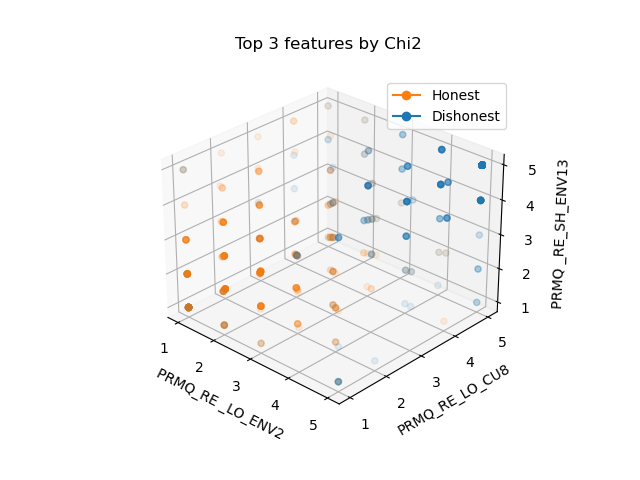

In [222]:
ax = plot_top_features(X_train, y_train, 3, rawdata.columns[:-1],score_func=chi2)

C:\Users\xps\AppData\Local\Temp/ipykernel_17120/864869132.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


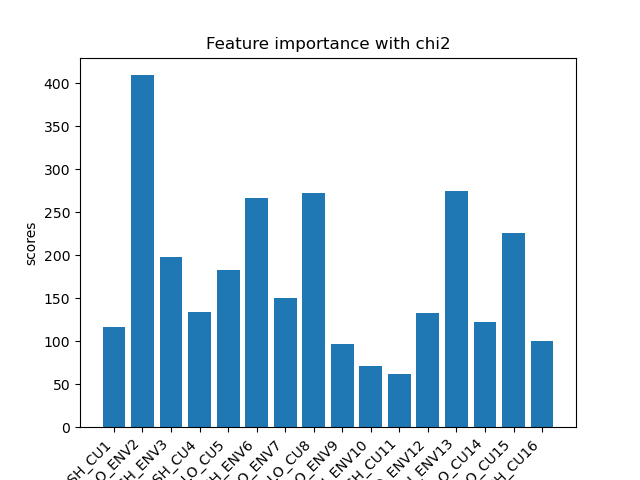

In [223]:
ax = plot_feature_importances(X_train,y_train, feature_names_in=rawdata.columns[:-1], score_func=chi2)
plt.show()

C:\Users\xps\AppData\Local\Temp/ipykernel_17120/864869132.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


<AxesSubplot:title={'center':'Feature importance with mutual_info_classif'}, xlabel='features', ylabel='scores'>

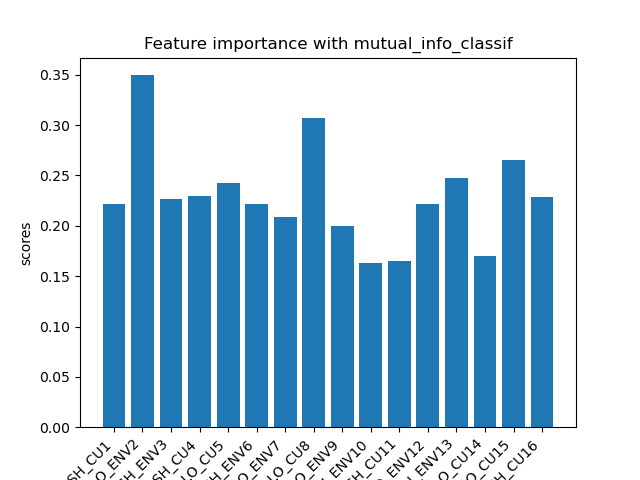

In [224]:
plot_feature_importances(X_train,y_train,feature_names_in=rawdata.columns[:-1], score_func=mutual_info_classif)

Feature selection experiments

In [225]:
models = [
    sklearn.svm.SVC(kernel='linear', random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE),
    sklearn.linear_model.LogisticRegression()
]
model_names = [
    'SVC',
    'Random Forest',
    'Logistic Regression'
]
percentiles = [5, 10, 30, 50, 80, 100]
feature_funs = ['chi2', 'mi', 'lasso']

Chi2 criterion

In [226]:
scores_chi2, features_chi2 = eval_for_all_datasets(
    datasets, models, model_names, percentiles,feature_select_func=chi2)
scores_chi2

5         10        30        50   \
BF_df_CTU    SVC                  0.741573  0.741573  0.775281  0.842697   
             Random Forest        0.741573  0.741573  0.730337  0.797753   
             Logistic Regression  0.741573  0.741573  0.775281  0.808989   
BF_df_OU     SVC                  0.641304  0.641304  0.804348  0.804348   
             Random Forest        0.804348  0.804348  0.804348  0.771739   
             Logistic Regression  0.804348  0.804348  0.804348  0.782609   
BF_df_V      SVC                  0.773196  0.773196  0.814433  0.793814   
             Random Forest        0.773196  0.773196  0.762887  0.793814   
             Logistic Regression  0.773196  0.773196  0.814433  0.845361   
IADQ_df      SVC                  0.811111  0.811111  0.811111  0.777778   
             Random Forest        0.811111  0.811111  0.822222  0.811111   
             Logistic Regression  0.811111  0.811111  0.811111  0.811111   
IESR_df      SVC                  0.930556  0.944444  0.944444  0.930556   
             Random Forest        0.902778  0.930556  0.930556  0.944444   
             Logistic Regression  0.930556  0.930556  0.916667  0.930556   
PHQ9_GAD7_df SVC                  0.950893  0.982143  0.982143  0.991071   
             Random Forest        0.950893  0.982143  0.982143  0.991071   
             Logistic Regression  0.950893  0.982143  0.982143  0.986607   
PRMQ_df      SVC                  0.829181   0.88968  0.875445  0.879004   
             Random Forest        0.829181  0.886121  0.882562  0.907473   
             Logistic Regression  0.829181   0.88968  0.871886  0.882562   
RAW_DDDT     SVC                  0.690355  0.746193  0.746193  0.736041   
             Random Forest        0.690355  0.730964  0.695431  0.690355   
             Logistic Regression  0.690355  0.746193  0.771574  0.736041   

                                       80        100  
BF_df_CTU    SVC                  0.831461  0.752809  
             Random Forest        0.808989  0.808989  
             Logistic Regression  0.797753  0.764045  
BF_df_OU     SVC                  0.782609  0.782609  
             Random Forest        0.782609  0.771739  
             Logistic Regression  0.771739  0.771739  
BF_df_V      SVC                  0.804124  0.773196  
             Random Forest        0.793814  0.793814  
             Logistic Regression  0.824742  0.762887  
IADQ_df      SVC                  0.833333  0.833333  
             Random Forest        0.822222  0.833333  
             Logistic Regression  0.788889  0.811111  
IESR_df      SVC                  0.930556  0.902778  
             Random Forest        0.944444  0.944444  
             Logistic Regression  0.916667  0.902778  
PHQ9_GAD7_df SVC                  0.986607  0.986607  
             Random Forest        0.982143  0.986607  
             Logistic Regression  0.986607  0.982143  
PRMQ_df      SVC                  0.875445  0.900356  
             Random Forest        0.928826  0.921708  
             Logistic Regression  0.879004   0.88968  
RAW_DDDT     SVC                  0.741117  0.751269  
             Random Forest        0.766497  0.766497  
             Logistic Regression  0.756345  0.725888

In [227]:
scores_chi2_diff = scores_chi2.subtract(scores_chi2[100],axis='index')
scores_chi2_diff

5         10        30        50   \
BF_df_CTU    SVC                 -0.011236 -0.011236  0.022472  0.089888   
             Random Forest       -0.067416 -0.067416 -0.078652 -0.011236   
             Logistic Regression -0.022472 -0.022472  0.011236  0.044944   
BF_df_OU     SVC                 -0.141304 -0.141304  0.021739  0.021739   
             Random Forest        0.032609  0.032609  0.032609       0.0   
             Logistic Regression  0.032609  0.032609  0.032609   0.01087   
BF_df_V      SVC                       0.0       0.0  0.041237  0.020619   
             Random Forest       -0.020619 -0.020619 -0.030928       0.0   
             Logistic Regression  0.010309  0.010309  0.051546  0.082474   
IADQ_df      SVC                 -0.022222 -0.022222 -0.022222 -0.055556   
             Random Forest       -0.022222 -0.022222 -0.011111 -0.022222   
             Logistic Regression       0.0       0.0       0.0       0.0   
IESR_df      SVC                  0.027778  0.041667  0.041667  0.027778   
             Random Forest       -0.041667 -0.013889 -0.013889       0.0   
             Logistic Regression  0.027778  0.027778  0.013889  0.027778   
PHQ9_GAD7_df SVC                 -0.035714 -0.004464 -0.004464  0.004464   
             Random Forest       -0.035714 -0.004464 -0.004464  0.004464   
             Logistic Regression  -0.03125       0.0       0.0  0.004464   
PRMQ_df      SVC                 -0.071174 -0.010676 -0.024911 -0.021352   
             Random Forest       -0.092527 -0.035587 -0.039146 -0.014235   
             Logistic Regression -0.060498       0.0 -0.017794 -0.007117   
RAW_DDDT     SVC                 -0.060914 -0.005076 -0.005076 -0.015228   
             Random Forest       -0.076142 -0.035533 -0.071066 -0.076142   
             Logistic Regression -0.035533  0.020305  0.045685  0.010152   

                                       80   100  
BF_df_CTU    SVC                  0.078652  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression  0.033708  0.0  
BF_df_OU     SVC                       0.0  0.0  
             Random Forest         0.01087  0.0  
             Logistic Regression       0.0  0.0  
BF_df_V      SVC                  0.030928  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression  0.061856  0.0  
IADQ_df      SVC                       0.0  0.0  
             Random Forest       -0.011111  0.0  
             Logistic Regression -0.022222  0.0  
IESR_df      SVC                  0.027778  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression  0.013889  0.0  
PHQ9_GAD7_df SVC                       0.0  0.0  
             Random Forest       -0.004464  0.0  
             Logistic Regression  0.004464  0.0  
PRMQ_df      SVC                 -0.024911  0.0  
             Random Forest        0.007117  0.0  
             Logistic Regression -0.010676  0.0  
RAW_DDDT     SVC                 -0.010152  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression  0.030457  0.0

In [228]:
scores_mi, features_mi = eval_for_all_datasets(
    datasets, models, model_names, percentiles,feature_select_func=mutual_info_classif)
scores_mi

5         10        30        50   \
BF_df_CTU    SVC                  0.741573  0.640449  0.775281  0.808989   
             Random Forest        0.741573  0.741573  0.820225  0.797753   
             Logistic Regression  0.764045  0.764045  0.775281  0.797753   
BF_df_OU     SVC                  0.641304  0.641304  0.804348  0.804348   
             Random Forest        0.804348  0.804348      0.75  0.782609   
             Logistic Regression  0.804348  0.804348  0.804348  0.804348   
BF_df_V      SVC                   0.71134   0.71134  0.814433  0.804124   
             Random Forest        0.731959  0.731959  0.762887  0.793814   
             Logistic Regression  0.731959  0.731959  0.824742  0.824742   
IADQ_df      SVC                  0.811111  0.788889  0.777778  0.777778   
             Random Forest        0.722222  0.722222  0.811111  0.811111   
             Logistic Regression  0.722222  0.788889  0.822222  0.811111   
IESR_df      SVC                  0.930556  0.930556  0.930556  0.930556   
             Random Forest        0.888889  0.930556  0.916667  0.944444   
             Logistic Regression  0.930556  0.944444  0.944444  0.930556   
PHQ9_GAD7_df SVC                  0.950893  0.982143  0.982143  0.982143   
             Random Forest        0.950893  0.982143  0.982143  0.982143   
             Logistic Regression  0.950893  0.982143  0.991071  0.982143   
PRMQ_df      SVC                  0.829181  0.882562  0.893238  0.875445   
             Random Forest        0.829181  0.879004  0.879004  0.903915   
             Logistic Regression  0.829181  0.850534  0.893238  0.871886   
RAW_DDDT     SVC                  0.680203  0.715736  0.756345  0.746193   
             Random Forest        0.680203   0.71066  0.741117  0.690355   
             Logistic Regression  0.680203  0.736041  0.736041  0.756345   

                                       80        100  
BF_df_CTU    SVC                  0.797753  0.752809  
             Random Forest        0.786517  0.808989  
             Logistic Regression  0.764045  0.764045  
BF_df_OU     SVC                  0.804348  0.782609  
             Random Forest         0.73913  0.771739  
             Logistic Regression  0.793478  0.771739  
BF_df_V      SVC                  0.762887  0.773196  
             Random Forest        0.793814  0.793814  
             Logistic Regression  0.824742  0.762887  
IADQ_df      SVC                  0.833333  0.833333  
             Random Forest        0.811111  0.833333  
             Logistic Regression  0.788889  0.811111  
IESR_df      SVC                  0.916667  0.902778  
             Random Forest        0.930556  0.944444  
             Logistic Regression  0.902778  0.902778  
PHQ9_GAD7_df SVC                  0.986607  0.986607  
             Random Forest        0.977679  0.986607  
             Logistic Regression  0.986607  0.982143  
PRMQ_df      SVC                  0.879004  0.900356  
             Random Forest        0.925267  0.921708  
             Logistic Regression  0.886121   0.88968  
RAW_DDDT     SVC                  0.741117  0.751269  
             Random Forest        0.766497  0.766497  
             Logistic Regression  0.756345  0.725888

In [229]:
scores_mi_diff = scores_mi.subtract(scores_mi[100],axis='index')
scores_mi_diff

5         10        30        50   \
BF_df_CTU    SVC                 -0.011236  -0.11236  0.022472   0.05618   
             Random Forest       -0.067416 -0.067416  0.011236 -0.011236   
             Logistic Regression       0.0       0.0  0.011236  0.033708   
BF_df_OU     SVC                 -0.141304 -0.141304  0.021739  0.021739   
             Random Forest        0.032609  0.032609 -0.021739   0.01087   
             Logistic Regression  0.032609  0.032609  0.032609  0.032609   
BF_df_V      SVC                 -0.061856 -0.061856  0.041237  0.030928   
             Random Forest       -0.061856 -0.061856 -0.030928       0.0   
             Logistic Regression -0.030928 -0.030928  0.061856  0.061856   
IADQ_df      SVC                 -0.022222 -0.044444 -0.055556 -0.055556   
             Random Forest       -0.111111 -0.111111 -0.022222 -0.022222   
             Logistic Regression -0.088889 -0.022222  0.011111       0.0   
IESR_df      SVC                  0.027778  0.027778  0.027778  0.027778   
             Random Forest       -0.055556 -0.013889 -0.027778       0.0   
             Logistic Regression  0.027778  0.041667  0.041667  0.027778   
PHQ9_GAD7_df SVC                 -0.035714 -0.004464 -0.004464 -0.004464   
             Random Forest       -0.035714 -0.004464 -0.004464 -0.004464   
             Logistic Regression  -0.03125       0.0  0.008929       0.0   
PRMQ_df      SVC                 -0.071174 -0.017794 -0.007117 -0.024911   
             Random Forest       -0.092527 -0.042705 -0.042705 -0.017794   
             Logistic Regression -0.060498 -0.039146  0.003559 -0.017794   
RAW_DDDT     SVC                 -0.071066 -0.035533  0.005076 -0.005076   
             Random Forest       -0.086294 -0.055838 -0.025381 -0.076142   
             Logistic Regression -0.045685  0.010152  0.010152  0.030457   

                                       80   100  
BF_df_CTU    SVC                  0.044944  0.0  
             Random Forest       -0.022472  0.0  
             Logistic Regression       0.0  0.0  
BF_df_OU     SVC                  0.021739  0.0  
             Random Forest       -0.032609  0.0  
             Logistic Regression  0.021739  0.0  
BF_df_V      SVC                 -0.010309  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression  0.061856  0.0  
IADQ_df      SVC                       0.0  0.0  
             Random Forest       -0.022222  0.0  
             Logistic Regression -0.022222  0.0  
IESR_df      SVC                  0.013889  0.0  
             Random Forest       -0.013889  0.0  
             Logistic Regression       0.0  0.0  
PHQ9_GAD7_df SVC                       0.0  0.0  
             Random Forest       -0.008929  0.0  
             Logistic Regression  0.004464  0.0  
PRMQ_df      SVC                 -0.021352  0.0  
             Random Forest        0.003559  0.0  
             Logistic Regression -0.003559  0.0  
RAW_DDDT     SVC                 -0.010152  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression  0.030457  0.0

Lasso feature importance/selection

In [230]:
scores_lasso, features_lasso = eval_for_all_datasets(
    datasets, models, model_names, percentiles,feature_select_func=lasso_importance)
scores_lasso

5         10        30        50   \
BF_df_CTU    SVC                  0.494382  0.494382  0.786517  0.808989   
             Random Forest        0.640449  0.640449  0.707865  0.786517   
             Logistic Regression  0.640449  0.640449  0.707865  0.775281   
BF_df_OU     SVC                  0.467391  0.467391   0.76087  0.793478   
             Random Forest        0.445652  0.445652  0.695652   0.76087   
             Logistic Regression  0.467391  0.467391      0.75  0.793478   
BF_df_V      SVC                  0.639175  0.639175  0.721649  0.762887   
             Random Forest        0.659794  0.659794  0.742268  0.701031   
             Logistic Regression  0.639175  0.639175  0.721649  0.742268   
IADQ_df      SVC                  0.722222  0.722222  0.777778  0.822222   
             Random Forest        0.722222  0.722222  0.822222  0.811111   
             Logistic Regression  0.722222  0.722222  0.811111  0.811111   
IESR_df      SVC                  0.902778  0.930556  0.861111  0.902778   
             Random Forest        0.930556  0.888889  0.902778  0.930556   
             Logistic Regression  0.916667  0.902778  0.847222  0.916667   
PHQ9_GAD7_df SVC                  0.950893  0.982143  0.982143  0.982143   
             Random Forest        0.950893  0.982143  0.977679  0.982143   
             Logistic Regression  0.950893  0.982143  0.977679  0.982143   
PRMQ_df      SVC                  0.829181  0.857651   0.88968  0.900356   
             Random Forest        0.829181  0.836299  0.882562  0.914591   
             Logistic Regression  0.829181  0.846975  0.896797  0.900356   
RAW_DDDT     SVC                  0.680203  0.720812  0.761421  0.741117   
             Random Forest        0.680203  0.746193  0.730964  0.736041   
             Logistic Regression  0.680203  0.736041  0.756345  0.751269   

                                       80        100  
BF_df_CTU    SVC                  0.764045  0.752809  
             Random Forest        0.752809  0.808989  
             Logistic Regression  0.786517  0.764045  
BF_df_OU     SVC                  0.804348  0.782609  
             Random Forest         0.73913  0.771739  
             Logistic Regression  0.793478  0.771739  
BF_df_V      SVC                  0.752577  0.773196  
             Random Forest        0.793814  0.793814  
             Logistic Regression  0.762887  0.762887  
IADQ_df      SVC                  0.822222  0.833333  
             Random Forest        0.788889  0.833333  
             Logistic Regression  0.811111  0.811111  
IESR_df      SVC                  0.930556  0.902778  
             Random Forest        0.944444  0.944444  
             Logistic Regression  0.902778  0.902778  
PHQ9_GAD7_df SVC                  0.982143  0.986607  
             Random Forest        0.991071  0.986607  
             Logistic Regression  0.982143  0.982143  
PRMQ_df      SVC                  0.896797  0.900356  
             Random Forest        0.921708  0.921708  
             Logistic Regression  0.886121   0.88968  
RAW_DDDT     SVC                  0.756345  0.751269  
             Random Forest        0.766497  0.766497  
             Logistic Regression  0.736041  0.725888

In [231]:
scores_lasso_diff = scores_lasso.subtract(scores_lasso[100],axis='index')
scores_lasso_diff

5         10        30        50   \
BF_df_CTU    SVC                 -0.258427 -0.258427  0.033708   0.05618   
             Random Forest       -0.168539 -0.168539 -0.101124 -0.022472   
             Logistic Regression -0.123596 -0.123596  -0.05618  0.011236   
BF_df_OU     SVC                 -0.315217 -0.315217 -0.021739   0.01087   
             Random Forest       -0.326087 -0.326087 -0.076087  -0.01087   
             Logistic Regression -0.304348 -0.304348 -0.021739  0.021739   
BF_df_V      SVC                 -0.134021 -0.134021 -0.051546 -0.010309   
             Random Forest       -0.134021 -0.134021 -0.051546 -0.092784   
             Logistic Regression -0.123711 -0.123711 -0.041237 -0.020619   
IADQ_df      SVC                 -0.111111 -0.111111 -0.055556 -0.011111   
             Random Forest       -0.111111 -0.111111 -0.011111 -0.022222   
             Logistic Regression -0.088889 -0.088889       0.0       0.0   
IESR_df      SVC                       0.0  0.027778 -0.041667       0.0   
             Random Forest       -0.013889 -0.055556 -0.041667 -0.013889   
             Logistic Regression  0.013889       0.0 -0.055556  0.013889   
PHQ9_GAD7_df SVC                 -0.035714 -0.004464 -0.004464 -0.004464   
             Random Forest       -0.035714 -0.004464 -0.008929 -0.004464   
             Logistic Regression  -0.03125       0.0 -0.004464       0.0   
PRMQ_df      SVC                 -0.071174 -0.042705 -0.010676       0.0   
             Random Forest       -0.092527 -0.085409 -0.039146 -0.007117   
             Logistic Regression -0.060498 -0.042705  0.007117  0.010676   
RAW_DDDT     SVC                 -0.071066 -0.030457  0.010152 -0.010152   
             Random Forest       -0.086294 -0.020305 -0.035533 -0.030457   
             Logistic Regression -0.045685  0.010152  0.030457  0.025381   

                                       80   100  
BF_df_CTU    SVC                  0.011236  0.0  
             Random Forest        -0.05618  0.0  
             Logistic Regression  0.022472  0.0  
BF_df_OU     SVC                  0.021739  0.0  
             Random Forest       -0.032609  0.0  
             Logistic Regression  0.021739  0.0  
BF_df_V      SVC                 -0.020619  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression       0.0  0.0  
IADQ_df      SVC                 -0.011111  0.0  
             Random Forest       -0.044444  0.0  
             Logistic Regression       0.0  0.0  
IESR_df      SVC                  0.027778  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression       0.0  0.0  
PHQ9_GAD7_df SVC                 -0.004464  0.0  
             Random Forest        0.004464  0.0  
             Logistic Regression       0.0  0.0  
PRMQ_df      SVC                 -0.003559  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression -0.003559  0.0  
RAW_DDDT     SVC                  0.005076  0.0  
             Random Forest             0.0  0.0  
             Logistic Regression  0.010152  0.0

In [232]:
scores_rf, features_rf = eval_for_all_datasets(
    datasets, models, model_names, percentiles,feature_select_func=rf_importance)
scores_rf

5         10        30        50   \
BF_df_CTU    SVC                  0.741573  0.741573  0.775281  0.842697   
             Random Forest        0.741573  0.741573  0.730337  0.797753   
             Logistic Regression  0.741573  0.741573  0.775281  0.808989   
BF_df_OU     SVC                  0.641304  0.641304  0.804348  0.804348   
             Random Forest        0.804348  0.804348  0.804348  0.782609   
             Logistic Regression  0.804348  0.804348  0.804348  0.804348   
BF_df_V      SVC                   0.71134  0.752577  0.814433  0.804124   
             Random Forest         0.71134   0.71134  0.762887  0.762887   
             Logistic Regression  0.731959  0.731959  0.814433  0.824742   
IADQ_df      SVC                  0.788889  0.788889  0.822222       0.8   
             Random Forest        0.788889  0.788889  0.811111  0.822222   
             Logistic Regression  0.788889  0.788889  0.822222  0.811111   
IESR_df      SVC                  0.930556  0.944444  0.930556  0.930556   
             Random Forest        0.930556  0.916667  0.930556  0.944444   
             Logistic Regression  0.930556  0.930556  0.930556  0.930556   
PHQ9_GAD7_df SVC                  0.950893  0.982143  0.982143  0.982143   
             Random Forest        0.950893  0.982143  0.982143  0.982143   
             Logistic Regression  0.950893  0.982143  0.982143  0.982143   
PRMQ_df      SVC                  0.829181  0.882562  0.900356  0.875445   
             Random Forest        0.829181  0.879004  0.879004  0.914591   
             Logistic Regression  0.829181  0.850534  0.893238  0.879004   
RAW_DDDT     SVC                  0.685279  0.720812  0.741117  0.736041   
             Random Forest        0.680203  0.746193  0.685279  0.700508   
             Logistic Regression  0.654822  0.736041  0.736041  0.746193   

                                       80        100  
BF_df_CTU    SVC                  0.831461  0.752809  
             Random Forest        0.808989  0.808989  
             Logistic Regression  0.808989  0.764045  
BF_df_OU     SVC                  0.804348  0.782609  
             Random Forest         0.76087  0.771739  
             Logistic Regression  0.793478  0.771739  
BF_df_V      SVC                  0.804124  0.773196  
             Random Forest        0.783505  0.793814  
             Logistic Regression  0.824742  0.762887  
IADQ_df      SVC                  0.822222  0.833333  
             Random Forest        0.811111  0.833333  
             Logistic Regression       0.8  0.811111  
IESR_df      SVC                  0.916667  0.902778  
             Random Forest        0.944444  0.944444  
             Logistic Regression  0.902778  0.902778  
PHQ9_GAD7_df SVC                  0.986607  0.986607  
             Random Forest        0.982143  0.986607  
             Logistic Regression  0.986607  0.982143  
PRMQ_df      SVC                  0.896797  0.900356  
             Random Forest        0.918149  0.921708  
             Logistic Regression  0.893238   0.88968  
RAW_DDDT     SVC                  0.736041  0.751269  
             Random Forest        0.761421  0.766497  
             Logistic Regression  0.756345  0.725888

In [233]:
def build_feature_list(dname):
    return pd.DataFrame({'chi2': features_chi2[dname], 'mi': features_mi[dname], 'lasso': features_lasso[dname]})

def build_binary_feature_table(dname, percentiles, feature_funs, full_feature_list):
    used_features = build_feature_list(dname)
    df = pd.DataFrame(index=pd.MultiIndex.from_product([percentiles, feature_funs]), columns=full_feature_list)
    for ftre in full_feature_list:
        for fun in feature_funs:
            for per in percentiles:
                if ftre in used_features[fun].loc[per]:
                    df[ftre].loc[(per,fun)] = 1
                else:
                    df[ftre].loc[(per,fun)] = 0
    return df

ft = build_binary_feature_table('PRMQ_df', percentiles, feature_funs, np.arange(0,len(datasets['PRMQ_df'].columns[:-1])))
prmq_cols = [col.replace('PRMQ_', '') for col in datasets['PRMQ_df'].columns[:-1]]
ft.columns = prmq_cols
ft

PR_SH_CU1 RE _LO_ENV2  PR_SH_ENV3 RE_SH_CU4 PR_LO_CU5 RE_SH_ENV6  \
5   chi2          0           1           0         0         0          0   
    mi            0           1           0         0         0          0   
    lasso         0           1           0         0         0          0   
10  chi2          0           1           0         0         0          0   
    mi            0           1           0         0         0          0   
    lasso         0           1           0         0         0          0   
30  chi2          0           1           0         0         0          1   
    mi            0           1           0         0         1          0   
    lasso         0           1           1         0         0          0   
50  chi2          0           1           1         0         1          1   
    mi            0           1           0         0         1          1   
    lasso         0           1           1         0         1          1   
80  chi2          1           1           1         1         1          1   
    mi            0           1           1         1         1          1   
    lasso         0           1           1         1         1          1   
100 chi2          1           1           1         1         1          1   
    mi            1           1           1         1         1          1   
    lasso         1           1           1         1         1          1   

          PR_LO_ENV7 RE_LO_CU8 RE_LO_ENV9 PR_SH_ENV10 PRMQ _RE_SH_CU11  \
5   chi2           0         0          0           0                0   
    mi             0         0          0           0                0   
    lasso          0         0          0           0                0   
10  chi2           0         0          0           0                0   
    mi             0         1          0           0                0   
    lasso          0         0          0           0                1   
30  chi2           0         1          0           0                0   
    mi             0         1          0           0                0   
    lasso          0         0          0           1                1   
50  chi2           1         1          0           0                0   
    mi             0         1          0           0                0   
    lasso          0         1          0           1                1   
80  chi2           1         1          0           0                0   
    mi             1         1          1           0                0   
    lasso          0         1          0           1                1   
100 chi2           1         1          1           1                1   
    mi             1         1          1           1                1   
    lasso          1         1          1           1                1   

          PR_LO_ENV12 PRMQ _RE_SH_ENV13 PRMQ _PR_LO_CU14 RE_LO_CU15 PR_SH_CU16  
5   chi2            0                 0                0          0          0  
    mi              0                 0                0          0          0  
    lasso           0                 0                0          0          0  
10  chi2            0                 1                0          0          0  
    mi              0                 0                0          0          0  
    lasso           0                 0                0          0          0  
30  chi2            0                 1                0          1          0  
    mi              0                 1                0          1          0  
    lasso           0                 1                0          0          0  
50  chi2            0                 1                0          1          0  
    mi              1                 1                0          1          1  
    lasso           0                 1                0          0          0  
80  chi2            1                 1                1          1

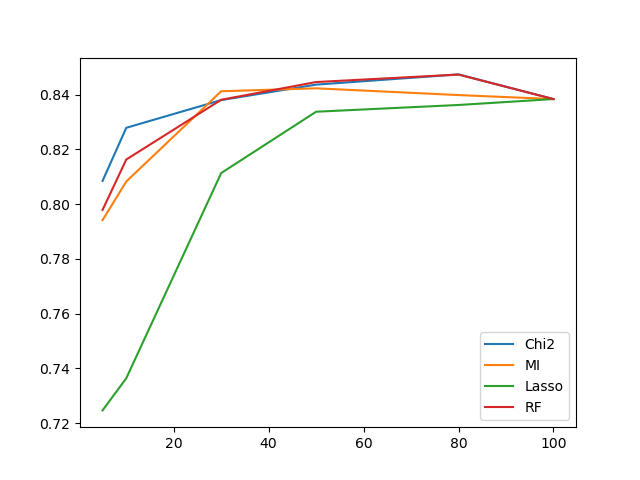

In [234]:
scores_chi2_avg = scores_chi2.mean()
scores_mi_avg = scores_mi.mean()
scores_lasso_avg = scores_lasso.mean()
scores_rf_avg = scores_rf.mean()
avg_scores = pd.DataFrame({"Chi2": scores_chi2_avg, "MI": scores_mi_avg, 'Lasso': scores_lasso_avg, 'RF': scores_rf_avg})
ax = plt.figure().add_subplot()
ax.plot(scores_chi2_avg.index, scores_chi2_avg)
ax.plot(scores_mi_avg.index, scores_mi_avg)
ax.plot(scores_lasso_avg.index, scores_lasso_avg)
ax.plot(scores_rf_avg.index, scores_rf_avg)
ax.legend(['Chi2', 'MI', 'Lasso', 'RF'])

Let's try adding a new feature: count of 5's in each row.

In [235]:
expanded_datasets = dict()
for key in datasets.keys():
    expanded_datasets[key] = datasets[key].copy()
    expanded_datasets[key].insert(loc=0, column = 'NMAX', value = datasets[key][datasets[key] == datasets[key].max(axis=0)[:-1].max()].count(1))

In [236]:
expanded_datasets['IADQ_df']

,NMAX,Pr1,Pr2,Pr3,FA1,FA2,FA3,FI1,FI2,FI3,CONDITION
0,1,4,2,3,2,2,2,2,2,1,H
1,0,2,3,2,3,2,1,3,2,3,H
2,4,4,3,3,4,4,4,3,3,3,H
3,0,3,3,2,1,3,2,3,2,3,H
4,1,3,2,2,3,3,3,4,3,3,H
...,...,...,...,...,...,...,...,...,...,...,...
445,9,4,4,4,4,4,4,4,4,4,D
446,6,4,3,4,4,3,3,4,4,4,D
447,6,3,4,4,4,4,4,3,3,4,D
448,3,3,4,4,3,3,3,3,4,3,D


In [237]:
train, val, test = preprocess(expanded_datasets['IADQ_df'], TARGET)

to_explore = expanded_datasets['IADQ_df']

target_column_ind = to_explore.columns.get_loc(TARGET)

X_train, y_train = separate_target(train, target_column_ind)
X_val, y_val = separate_target(val, target_column_ind)
X_test, y_test = separate_target(test, target_column_ind)
# check_split_integrity(rawdata, X_train, X_val, X_test)

C:\Users\xps\AppData\Local\Temp/ipykernel_17120/864869132.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_names_in,rotation=45,ha='right')


<AxesSubplot:title={'center':'Feature importance with rf_importance'}, xlabel='features', ylabel='scores'>

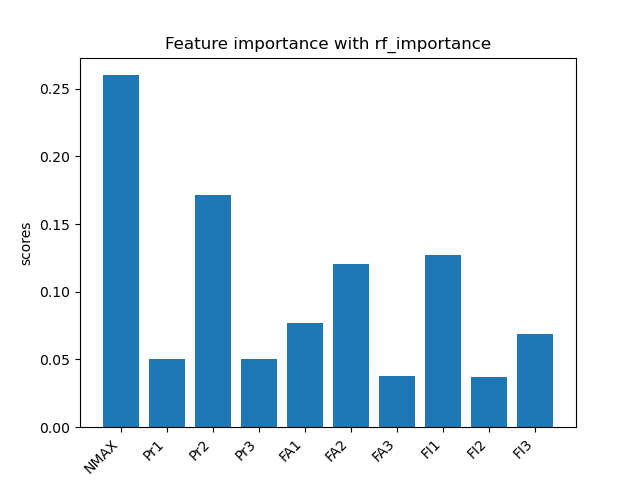

In [243]:
plot_feature_importances(X_train, y_train, feature_names_in=to_explore.columns[:-1],score_func = rf_importance)

In [245]:
exp_chi2_scores, exp_chi2_features = eval_for_all_datasets(expanded_datasets, models, model_names, feature_select_func=chi2)

In [251]:
exp_chi2_features

,BF_df_CTU,BF_df_OU,BF_df_V,IADQ_df,IESR_df,PHQ9_GAD7_df,PRMQ_df,RAW_DDDT
5,[0],[0],[0],[0],"[0, 19]",[0],[0],[11]
10,[0],[0],[0],[0],"[0, 9, 19]","[0, 8]","[0, 2]","[2, 11]"
30,"[0, 5, 7]","[0, 7, 8]","[0, 7, 8]","[0, 4, 7]","[0, 9, 14, 15, 17, 19, 20]","[0, 2, 6, 7, 8]","[0, 2, 6, 8, 13]","[2, 4, 8, 11]"
50,"[0, 3, 5, 7, 8]","[0, 3, 5, 7, 8]","[0, 1, 5, 7, 8]","[0, 2, 4, 7, 9]","[0, 2, 8, 9, 13, 14, 15, 17, 18, 19, 20]","[0, 1, 2, 6, 7, 8, 13, 14]","[0, 2, 3, 5, 6, 8, 13, 15]","[1, 2, 4, 8, 10, 11]"
80,"[0, 1, 3, 4, 5, 7, 8, 10]","[0, 1, 3, 5, 7, 8, 9, 10]","[0, 1, 3, 5, 7, 8, 9, 10]","[0, 2, 3, 4, 5, 7, 8, 9]","[0, 2, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15]","[1, 2, 3, 4, 6, 7, 8, 9, 10, 11]"
100,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"


In [ ]:
exp_chi2_scores, exp_chi2_features = eval_for_all_datasets(expanded_datasets, models, model_names, feature_select_func=mutual_info_classif)

OLD STUFF

In [239]:
data_exp = add_interactions(rawdata, col_names=['Pr1', 'Pr2', 'Pr3'])
data_exp = add_interactions(data_exp, col_names=['FA1', 'FA2', 'FA3'])
data_exp = add_interactions(data_exp, col_names=['FI1', 'FI2', 'FI3'])

X_exp = data_exp.drop([TARGET],axis=1)
y_exp = data_exp[TARGET]

KeyError: 'Pr1'

In [ ]:
X_exp_train, X_exp_tv, y_exp_train, y_exp_tv = train_test_split(X_exp, y_exp, test_size=TESTSIZE,random_state=RANDOM_STATE)

sc_exp = StandardScaler()
X_exp_train = sc_exp.fit_transform(X_exp_train)
X_exp_tv = sc_exp.transform(X_exp_tv)

X_exp_val, X_exp_test, y_exp_val, y_exp_test = train_test_split(X_exp_tv, y_tv, test_size=VALSIZE,random_state=RANDOM_STATE)

NameError: name 'y_tv' is not defined

In [ ]:
np.sum(y_exp_train == 1)/np.sum(y_exp_train==0)

0.9444444444444444

In [ ]:
# lasso logistic model with no interactions
loglasso = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=1000
).fit(X_train, y_train)

loglasso.score(X_val, y_val)

0.8208955223880597

In [ ]:
loglasso.coef_

array([[ 0.34551073, -0.7710643 , -0.32557168, -0.77609551, -0.70529487,
         0.14356044, -0.23835024,  0.01854565, -0.53042108]])

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso.coef_.nonzero()[-1]].to_numpy()}')

Used features:
['Pr1' 'Pr2' 'Pr3' 'FA1' 'FA2' 'FA3' 'FI1' 'FI2' 'FI3']


In [ ]:
# lasso logistic model with interactions
loglasso_exp = sklearn.linear_model.LogisticRegressionCV(
    cv=5,
    random_state=RANDOM_STATE, 
    penalty='l1', 
    solver='liblinear',
    max_iter=10000
).fit(X_exp_train, y_exp_train)

loglasso_exp.score(X_exp_val, y_exp_val)

0.8208955223880597

In [ ]:
loglasso_exp.coef_

array([[ 0.39602845, -0.1284921 ,  0.        , -1.00973356, -0.20137843,
         0.5125152 , -0.14046987,  0.45907492,  0.        ,  0.        ,
         0.4720242 , -0.5441529 , -0.77596032,  0.        ,  0.22291391,
        -0.89326129,  0.        ,  0.        , -0.02781083, -0.46856733,
        -0.43026883]])

In [ ]:
print(f'Used features:\n{data_exp.columns[loglasso_exp.coef_.nonzero()[-1]].to_numpy()}')

Used features:
['Pr1' 'Pr2' 'FA1' 'FA2' 'FA3' 'FI1' 'FI2' 'Pr1.Pr2' 'Pr1.Pr3' 'Pr2.Pr3'
 'FA1.FA2' 'FA1.FA3' 'FI1.FI2' 'FI1.FI3' 'FI2.FI3']


In [ ]:
# ridge regression
logr = LogisticRegression(penalty='l2',random_state=RANDOM_STATE)
rfe = RFE(estimator=logr, n_features_to_select=5, step=1)
X_train_5 = rfe.fit_transform(X_train, y_train)

In [ ]:
X_val_5 = rfe.transform(X_val)
logr_5 = LogisticRegression(penalty='l2', random_state=RANDOM_STATE).fit(X_train_5, y_train)
logr_5.score(X_val_5, y_val)

0.8059701492537313

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
random_forest_params =  {
        'n_estimators': [1, 2, 5, 10],
        'max_depth': [1, 2, 3],
        'random_state': [RANDOM_STATE],
    }
model = RandomForestClassifier()
random_forest = GridSearchCV(model, random_forest_params)
random_forest.fit(X_train, y_train)
random_forest.score(X_val, y_val)

0.8208955223880597